In [75]:
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import cv2
from pymatting.alpha import estimate_alpha,estimate_alpha_knn,estimate_alpha_lbdm,estimate_alpha_lkm
from pymatting import blend,estimate_foreground
from pymatting.foreground.estimate_foreground_ml_cupy import estimate_foreground_ml_cupy


from torchvision import transforms
from torchvision.models.segmentation import deeplabv3_resnet101

from utils import generate_trimap


In [65]:
model: torch.nn.Module = deeplabv3_resnet101(pretrained=True)

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
preprocess = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]
)


img = Image.open("images/cat_hard.jpg")
img_easy = Image.open("images/cat_easy.jpg")
img_array = np.array(img) / 255
img_easy_array = np.array(img2) / 255

input_tensor = preprocess(img)
input_batch = input_tensor.unsqueeze(0)

input_tensor_easy = preprocess(img2)
input_batch_easy = input_tensor_easy.unsqueeze(0)


device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
input_batch = input_batch.to(device)
input_batch_easy = input_batch_easy.to(device)
model = model.to(device)

with torch.no_grad():
    model.eval()
    output = model(input_batch)["out"][0].softmax(dim=0)
    output_easy = model(input_batch_easy)["out"][0].softmax(dim=0)


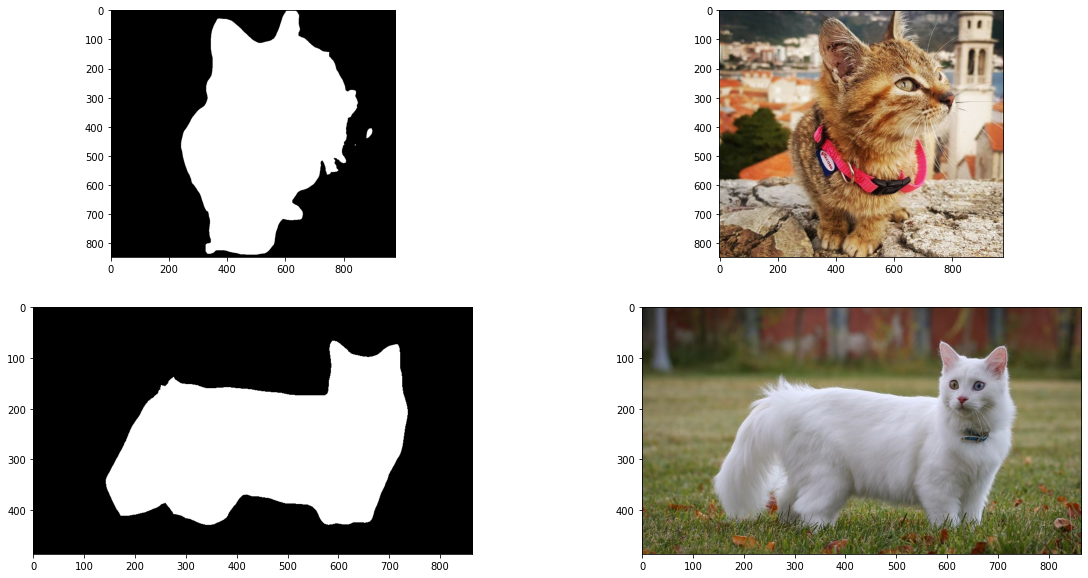

In [66]:
out = output.argmax(0).cpu().numpy()
seg_mask = np.vectorize(lambda pix : 0 if pix == 0 else 255)(out)[...,np.newaxis]

out_easy = output_easy.argmax(0).cpu().numpy()
seg_mask_easy = np.vectorize(lambda pix : 0 if pix == 0 else 255)(out_easy)[...,np.newaxis]

f, axarr = plt.subplots(2,2,figsize=(20, 10))
axarr[0,0].imshow(seg_mask,cmap="gray")
axarr[0,1].imshow(img_array)

axarr[1,0].imshow(seg_mask_easy,cmap="gray")
axarr[1,1].imshow(img_easy_array)

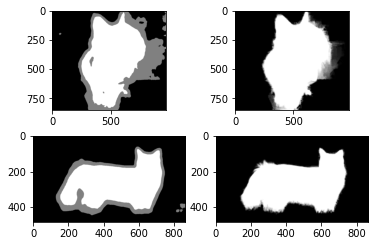

In [76]:

fg_probs = (1.0 - output[0]).cpu().numpy()
fg_probs2 =  (1.0 - output2[0]).cpu().numpy()

trimap = generate_trimap(fg_probs, 3, 0.95)
trimap_easy = generate_trimap(fg_probs2, 3, 0.95)


alpha = estimate_alpha(
    img_array,
    trimap,
)

alpha_easy = estimate_alpha(
    img_easy_array,
    trimap_easy,
)
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(trimap,cmap="gray")
axarr[0,1].imshow(alpha,cmap="gray")

axarr[1,0].imshow(trimap_easy,cmap="gray")
axarr[1,1].imshow(alpha_easy,cmap="gray")


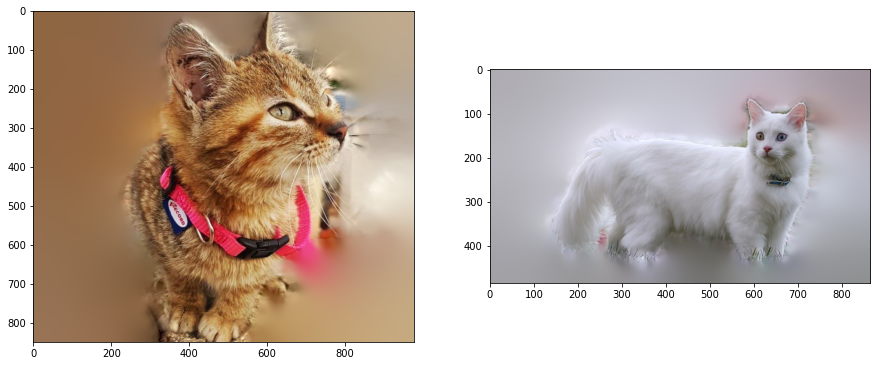

In [77]:
fg = estimate_foreground(img_array,alpha)
fg_easy = estimate_foreground(img_easy_array,alpha_easy)

f, axarr = plt.subplots(1,2,figsize=(15,10))
axarr[0].imshow(fg)
axarr[1].imshow(fg_easy)

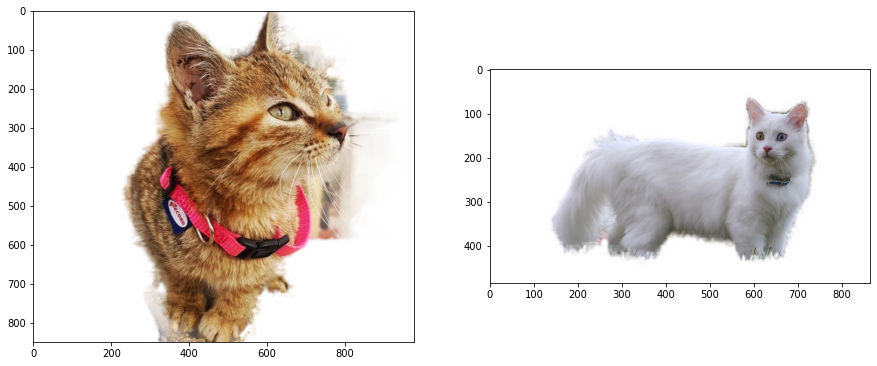

In [78]:
bg = np.ones_like(fg.shape)
b = blend(fg,bg,alpha)
b_easy = blend(fg_easy,bg,alpha_easy)


f, axarr = plt.subplots(1,2,figsize=(15, 10))
axarr[0].imshow(b)
axarr[1].imshow(b_easy)